In [ ]:
import pandas as pd
import gzip
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Shareddrives/519 Project/Data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

#gift_card_path = os.path.join(path, 'Gift_Cards_5.json.gz')
#df = getDF(electronics_path)

electronics_path = os.path.join(path, 'electronics_downsampled_pos_neg_binary.csv')
df = pd.read_csv(electronics_path)
#df = df[['reviewText', 'overall']]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#preprocessing

#TODO: add in Dan's preprocessing code
df = df[['reviewText', 'pos_neg']]
df = df.rename(columns = {'pos_neg': 'overall'})

df = df[df['reviewText'].notna()]
print(df.columns)

#from spell_check import fixSentence
#df['reviewText'] = df['reviewText'].apply(lambda x: fixSentence(x))

#print('CHECKPOINT: Spell Check Complete')

Index(['reviewText', 'overall'], dtype='object')


In [ ]:
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

def tokenize(sentence):
  tokens = token.tokenize(sentence)
  filtered = [x for x in tokens if not x in stop_words]
  return filtered

df['tokenized'] = df['reviewText'].apply(tokenize)
df = df[['tokenized', 'overall']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#df['overall_adj'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)

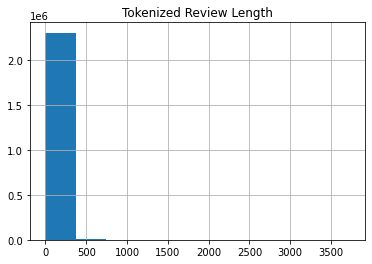

In [ ]:
len_tokens = [len(i) for i in df['tokenized']]
pd.Series(len_tokens).hist()
plt.title('Tokenized Review Length')
plt.show()
pd.Series(len_tokens).describe()

df['len'] = df['tokenized'].apply(lambda x: len(x))
df = df.loc[df['len'] >= 4]

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = .2, random_state = 42)

train_json = train_df.to_json(orient = 'records')
train_json_result = json.loads(train_json)
print(train_json)
with open('sample_data/train_gift_cards.json', 'w') as f:
  for entry in train_json_result:
    json.dump(entry, f)
    f.write('\n')

test_json = test_df.to_json(orient = 'records')
test_json_result = json.loads(test_json)
with open('sample_data/test_gift_cards.json', 'w') as f:
  for entry in test_json_result:
    json.dump(entry, f)
    f.write('\n')

In [ ]:
MAX_LEN = 277

In [ ]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets


TOKENS = data.Field(lower = True, batch_first = True)
SCORE = data.LabelField(dtype = torch.float)

fields = {'tokenized': ('tokens', TOKENS), 'overall': ('score', SCORE)}
train_data, test_data = data.TabularDataset.splits(
    path = 'sample_data',
    train = 'train_gift_cards.json',
    test = 'test_gift_cards.json',
    format = 'json',
    fields = fields
)
print(vars(train_data[0]))

{'tokens': ['a', 'great', 'way', 'get', 'want'], 'score': 1}


In [ ]:
TOKENS.build_vocab(train_data, 
                   max_size = 10000,
                   vectors = "glove.6B.100d", 
                   unk_init = torch.Tensor.normal_)
SCORE.build_vocab(train_data)

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator = data.BucketIterator(train_data, sort_key = lambda x: x.tokens, batch_size= 32, device = device)
test_iterator = data.BucketIterator(test_data, sort_key = lambda x: x.tokens, batch_size= 1, device = device)

In [ ]:
'''
model architecture taken from: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb
'''
import torch.nn as nn
import torch.nn.functional as F

class CNN_Text(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, 
                 vector_size, n_filters, 
                 filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        # Create word embeddings from the input words     
        self.embedding = nn.Embedding(vocab_size, vector_size, 
                                      padding_idx = pad_idx)
        
        # Specify convolutions with filters of different sizes (fs)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, vector_size)) 
                                    for fs in filter_sizes])
        
        # Add a fully connected layer for final predicitons
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # Drop some of the nodes to increase robustness in training
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self, text):
        '''Forward path of the network.'''       
        # Get word embeddings and formt them for convolutions
        embedded = self.embedding(text).unsqueeze(1)
        
        # Perform convolutions and apply activation functions
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        # Pooling layer to reduce dimensionality    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Dropout layer
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.linear(cat)

In [ ]:
input_dim = len(TOKENS.vocab)
embedding_dim = 100
n_filters = 100
filter_sizes = [1,2,3,4]
output_dim = 1
dropout = .5
pad_idx = TOKENS.vocab.stoi[TOKENS.pad_token]

model = CNN_Text(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)

In [ ]:
pretrained_embeddings = TOKENS.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

unk_idx = TOKENS.vocab.stoi[TOKENS.unk_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
"""
Basic train loop for cnn
"""
def train_cnn(model, iterator, optimizer, criterion, epochs=10):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    
    model = model.to(device)
    model.train()

    accuracy_list = []
    loss_list = []
    for epoch in range(epochs):
      epoch_acc = 0
      epoch_loss = 0
      for batch in iterator:
        optimizer.zero_grad()
        print(len)
        outputs = model(batch.tokens).squeeze(1)
        loss = criterion(outputs, batch.score)
        epoch_acc += binary_accuracy(outputs, batch.score).item()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

      epoch_acc = epoch_acc / len(iterator)
      epoch_loss = epoch_loss / len(iterator)
      accuracy_list.append(epoch_acc)
      loss_list.append(epoch_loss)
      print('Epoch Num: %d, Accuracy: %.4f, Loss: %.4f' % (epoch + 1, epoch_acc, epoch_loss))

    final_training_accuracy = accuracy_list[-1]     
    final_training_loss = loss_list[-1]
    return final_training_loss, final_training_accuracy

train_cnn(model, train_iterator, optimizer, criterion)

KeyboardInterrupt: ignored

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()